In [1]:
from scipy.stats import gaussian_kde
import numpy as np 
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

# Aux Functions

In [ ]:
def plot_inventory(initial_inventory, nb_episodes, trader_times, run_names, run_labels, pdf_name, title, metric='executed'):
    """ 
        Plot the average executed inventory.
        Note that 'action' or 'executed' can be plotted.
        With 'action', the plot will exceed 100%.
        Default is 'executed'.
    """

    actions = {}
    for i, run_name in enumerate(run_names):
        with open(f'data_wandb/dictionaries/{run_name}.pkl', 'rb') as f:
            dic = pickle.load(f)
        actions[run_labels[i]] = dic[metric]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    ep_lengths = []
    for key, values in actions.items():
        inventory = np.zeros((nb_episodes, len(trader_times)))
        for i in range(nb_episodes):
            inventory[i][:len(values[i])] = values[i]
            if key == 'DDQN':
                ep_lengths.append(len(values[i])) 

        inventory = np.cumsum(inventory, axis=1) / initial_inventory
        mean_inventory = inventory.mean(axis=0)
        std_inventory = inventory.std(axis=0)

        # Plot mean curve
        ax1.plot(trader_times, mean_inventory, label=key)

        # Shaded area for ±1 std
        ax1.fill_between(trader_times,
                        mean_inventory - std_inventory,
                        mean_inventory + std_inventory,
                        alpha=0.3)
            

    ax1.set_ylabel('Executed Inventory (%)')
    ax1.set_title(f'{title}')
    ax1.grid(True)
    ax1.legend()

    trader_time_step = trader_times[1] - trader_times[0]
    ax2.hist(trader_time_step * np.array(ep_lengths), bins=30, density=True, label='DDQN')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Density')
    ax2.set_title(f'Episode Length Distribution')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    # plt.savefig(f'plots/inventory/{pdf_name}.pdf', bbox_inches='tight')
    plt.show()
    plt.close()

In [19]:
def plot_is(run_names, run_labels, pdf_name, title, kde_only=True):

    final_is = {}

    for i, run_name in enumerate(run_names):
        with open(f'data_wandb/dictionaries/{run_name}.pkl', 'rb') as f:
            dic = pickle.load(f)
        final_is[run_labels[i]] = dic['final_is']

    plt.figure(figsize=(7, 5))

    maxi = max(
        max(np.abs(np.max(values)), np.abs(np.min(values)))
        for values in final_is.values()
    )
    x = np.linspace(-maxi, maxi, 1000)

    for key, values in final_is.items():
        print(f'Method {key}')
        print(f'Mean: {np.mean(values):.2f}, Std: {np.std(values):.2f} \n')
        kde = gaussian_kde(values)
        y_kde = kde(x)
        
        if not kde_only:
            plt.hist(values, bins=30, density=True, alpha=0.3, label=f'{key}')

        plt.plot(x, y_kde, label=f'{key}')

    plt.xlabel('Implementation Shortfall')
    plt.ylabel('Density')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f'plots/implementation_shortfall/{pdf_name}.pdf', bbox_inches='tight')
    plt.show()

# Plots

## glbpbi4x

Method DDQN
Mean: -1.30, Std: 2.34 

Method TWAP
Mean: 0.04, Std: 4.40 

Method Front Load
Mean: -1.30, Std: 2.34 

Method Best Volume
Mean: 0.23, Std: 3.53 



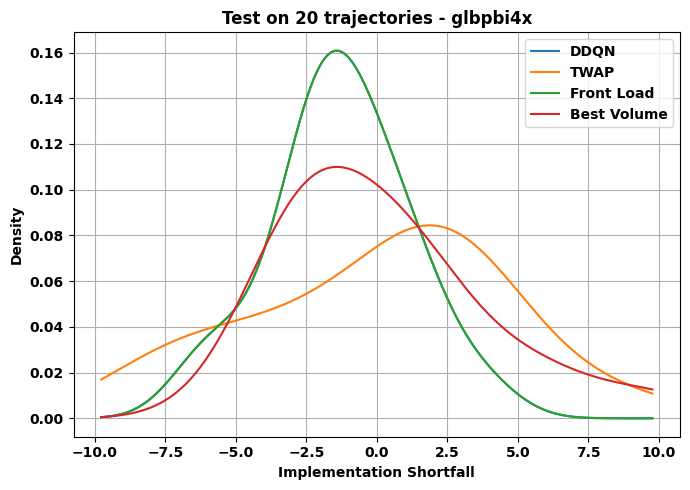

In [22]:
nb_episodes = 20
run_id = 'glbpbi4x'
types = ['ddqn', 'twap', 'front_load', 'best_volume']
run_names = [f'{type}_{run_id}' for type in types]
run_labels = ['DDQN', 'TWAP', 'Front Load', 'Best Volume']
pdf_name = 's_11_ddqns'
title = f'Test on {nb_episodes} trajectories - {run_id}'
plot_is(run_names, run_labels, pdf_name, title)

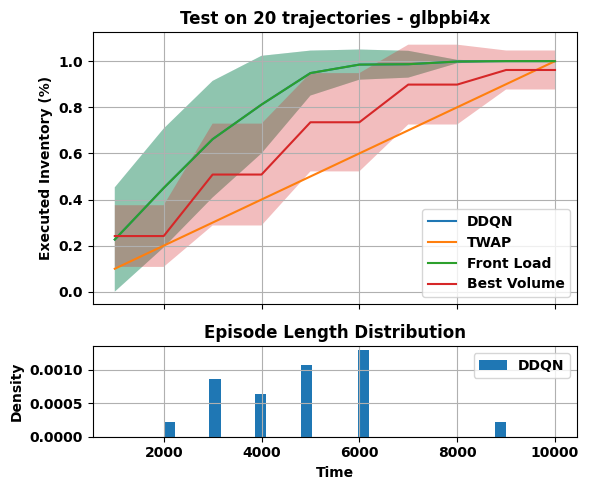

In [ ]:
initial_inventory = 30
nb_episodes = 20
th = 10000
ts = 1000
trader_times = np.arange(0, th + ts, ts) 
trader_times = trader_times[1:]

run_id = 'glbpbi4x'
run_ids = [run_id] 
run_names = [f'ddqn_{run_id}' for run_id in run_ids]
# run_names += ['twap_5ym1biox', 'back_load_5ym1biox', 'front_load_5ym1biox', 'front_load_1_5ym1biox']

types = ['ddqn', 'twap', 'front_load', 'best_volume']
run_names = [f'{tp}_{run_id}' for tp in types]
run_labels = ['DDQN', 'TWAP', 'Front Load', 'Best Volume']
pdf_name = 's_11'
title = f'Test on {nb_episodes} trajectories - {run_id}' 
plot_inventory(initial_inventory, nb_episodes, trader_times, run_names, run_labels, pdf_name, title)

## unf4ls2t

Method DDQN
Mean: -0.25, Std: 3.27 

Method Front Load
Mean: -0.27, Std: 2.30 

Method Best Volume
Mean: -0.24, Std: 2.66 



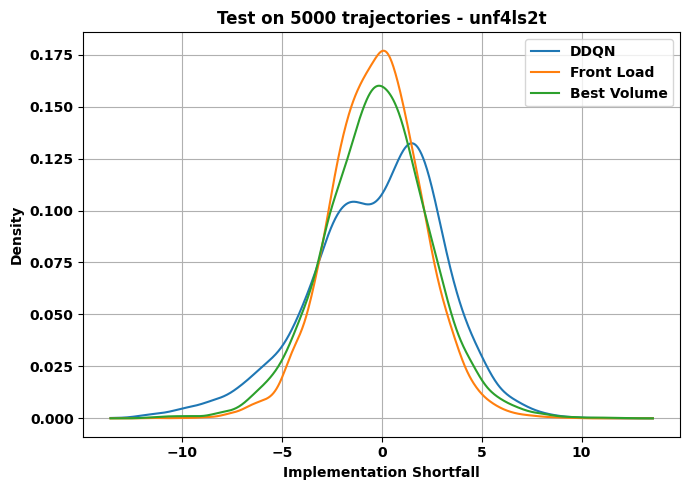

In [58]:
nb_episodes = 5000
run_id = 'unf4ls2t'
types = ['ddqn', 'front_load', 'best_volume']
run_names = [f'{type}_{run_id}' for type in types]
run_labels = ['DDQN', 'Front Load', 'Best Volume']
pdf_name = 's_11_ddqns'
title = f'Test on {nb_episodes} trajectories - {run_id}'
plot_is(run_names, run_labels, pdf_name, title)

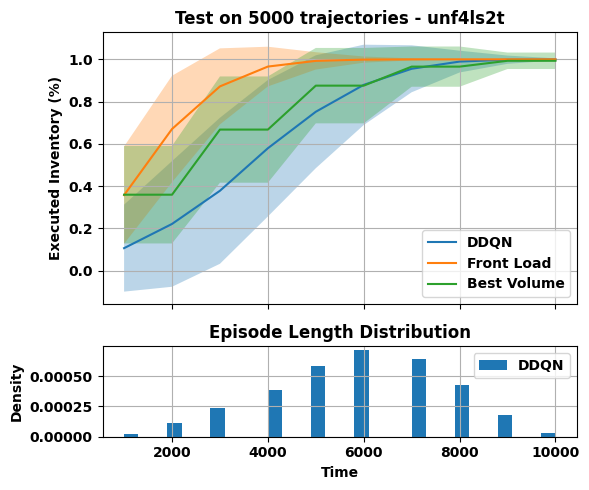

In [59]:
initial_inventory = 25
nb_episodes = 5000
th = 10000
ts = 1000
trader_times = np.arange(0, th + ts, ts) 
trader_times = trader_times[1:]

run_id = 'unf4ls2t'
run_ids = [run_id] 
run_names = [f'ddqn_{run_id}' for run_id in run_ids]
# run_names += ['twap_5ym1biox', 'back_load_5ym1biox', 'front_load_5ym1biox', 'front_load_1_5ym1biox']

types = ['ddqn', 'front_load', 'best_volume']
run_names = [f'{tp}_{run_id}' for tp in types]
run_labels = ['DDQN', 'Front Load', 'Best Volume']
pdf_name = 's_11'
title = f'Test on {nb_episodes} trajectories - {run_id}' 
plot_inventory(initial_inventory, nb_episodes, trader_times, run_names, run_labels, pdf_name, title)